# A Demo to compute consesus motif using test data

In [1]:
import h5py
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler

In [2]:
import sys
sys.path.append("../Scripts/")

from models import NaiveNet_v1
from util_ig import random_baseline_integrated_gradients, calculate_outputs_and_gradients
from util_cm import cal_consensus_motif_2,helper
from train_utils import RMdata

In [16]:
from plotseqlogo import seqlogo, seqlogo_fig

Using TensorFlow backend.
/home/zitao/anaconda3/envs/multirm/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zitao/anaconda3/envs/multirm/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zitao/anaconda3/envs/multirm/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zitao/anaconda

2021-03-02 20:42:20,067 [WARNING] From /home/zitao/anaconda3/envs/multirm/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

../Scripts/plotseqlogo.py:44: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
../Scripts/plotseqlogo.py:45: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


In [6]:
length = 51
num_task = 12
data_path = '../Data/data_12RM.h5'
model_weights = '../Weights/NaiveNet/trained_model_51seqs.pkl'     # consensus_motif only
percentage = 0.5                                                   # percentage of true positive samples 
use_embedding = False
radius = length // 2
RMs = ['hAm','hCm','hGm','hUm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol']
w = 8                                                              # window size to aggregate ig
k = 2                                                              # top k window to select
data_type = 'test'
RM_index = 7
RM = RMs[RM_index]

In [ ]:
model = NaiveNet_v1(input_size=length,num_task=num_task).cuda()
model.load_state_dict(torch.load(model_weights))

In [ ]:
dataset = RMdata(data_path,use_embedding=use_embedding,length=length,mode=data_type)

In [ ]:
X, y = dataset[:]

In [ ]:
if not use_embedding:
    X = X.view(X.size(0),-1,4).transpose(1,2)
y_pred = model(X)

In [ ]:
multi_ind_high = [i[0]for i in sorted(enumerate(y_pred[RM_index][:]), key=lambda x:x[1],reverse=True) if (y[i[0],RM_index]==1)]

In [ ]:
attributions = []
for j in range(len(multi_ind_high)):
    attribution = random_baseline_integrated_gradients(torch.unsqueeze(X[multi_ind_high[j],:],0), model, calculate_outputs_and_gradients, \
                                                        index = RM_index,steps=50, num_random_trials=10, cuda=None)
    attributions.append(attribution)
attributions = np.concatenate(attributions,0)

In [ ]:
X_high_nucleo = pd.read_hdf(data_path,'%s_in_nucleo'%(data_type)).iloc[sorted(multi_ind_high),500-radius:501+radius]

In [ ]:
short_seqs, scores = helper(attributions,X_high_nucleo,data_type,length,RM,download=True,w=8,k=2)

In [ ]:
!Rscript alignment.R 

In [11]:
data_type = 'train'

In [12]:
aligned_short_seqs = pd.read_csv('../Seqs/%s_%s_%d_wid%d_aligned.csv'%(data_type,RM,length,w),header=None)[0]
scores = pd.read_csv('../Seqs/%s_%s_%d_wid%d_top%d_score.csv'%(data_type,RM,length,w,k),header=None)[0]

In [13]:
aligned_short_seqs.head()

0    ----AAAGAAAA----
1    ----AAAAAAAA----
2    ----TAATAAAA----
3    ----AAATAAAT----
4    ----AATTAAAT----
Name: 0, dtype: object

In [14]:
consensus_motif, ig_scores = cal_consensus_motif_2(aligned_short_seqs,scores,eps=0.3)

class:0 score:0.38262
class:1 score:0.43371
class:2 score:0.34274
class:3 score:0.35848
class:4 score:0.40487
class:5 score:0.42273
class:6 score:0.40005
class:7 score:0.33906
class:8 score:0.36785
class:9 score:0.37591
class:10 score:0.42228
class:11 score:0.45272


In [18]:
def trim(data):
    '''
    trim edge nucleoties
        Input data: (length,4)
    '''
    length, _ = data.shape
    outs = [] 
    for i in range(length):
        if (data[i,0] != data[i,1]) or (data[i,0] != data[i,2]) or (data[i,0] != data[i,3]):
            outs.append(data[i,:].tolist())
    result = np.vstack(outs)
    return result

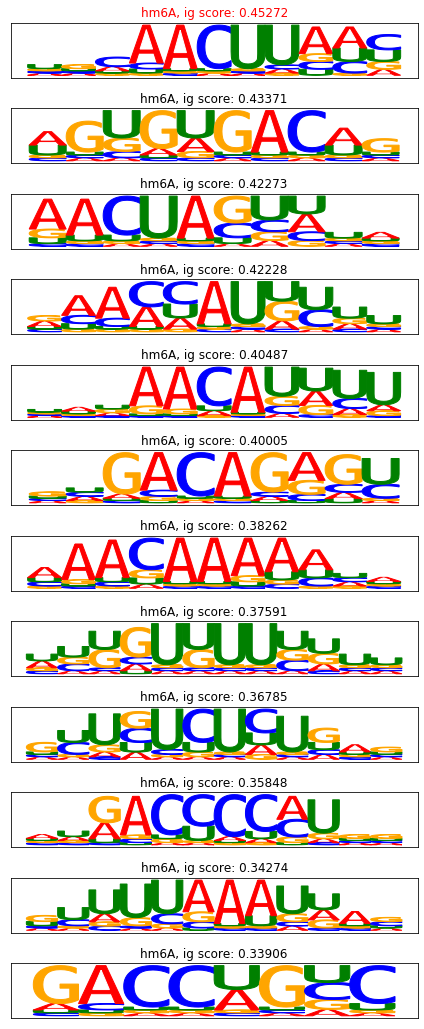

In [20]:
n_cluster = consensus_motif.shape[0]
score = ig_scores
score_max = np.max(score)
ig, axes = plt.subplots(n_cluster,1,figsize=(6,1.2*n_cluster))


for j in range(n_cluster):
    color = 'k'
    if score[j] == score_max:
        color = 'r'
    cur_ax = axes[j]
    cur_ax.set_title('%s, ig score: %.5f'%(RM,score[j]),color=color)

    # trim weights
    letter_heights = trim(consensus_motif[j,:].T)
    seqlogo(letter_heights=letter_heights,vocab='RNA',ax=cur_ax)
plt.tight_layout() 
#plt.savefig('../Figs/consensus_motif/%s_cm.pdf'%(RM))